Here I am going to show how we can use the MADGICS component separation method to correct reddening features in astrophysical spectra. For a broader overview of MADGICS, see `spectral_separation_tutorial.ipynb` in this repository.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

First, let's make some simulated spectra with some emission and some absorption lines. Here we are simulated 1000 spectra with 300 wavelength bins.

In [2]:
n_spec = 1000
n_wavelengths = 300

In [3]:
def gaussian(x, mu, sigma):
    coeff = 1 / np.sqrt(2 * np.pi * sigma**2)
    return coeff * np.exp(-(x - mu)**2/(2 * sigma**2))

In [189]:
def add_spectral_line(spectra, wavelength_index, width, ampl = 0.1, emission = True):
    num_wavelengths, num_spec = spectra.shape
    sign = 1 if emission else -1
    line_fluxes = sign * np.random.uniform(2,5, num_spec)
    
    emission_line = gaussian(np.arange(n_wavelengths), wavelength_index, np.sqrt(width))

    return spectra + line_fluxes * np.repeat(np.expand_dims(emission_line,0), num_spec, axis=0).T

In [223]:
random_spectra = np.random.rand(n_wavelengths, n_spec) - 0.5
spectra = add_spectral_line(random_spectra, 100, 5)
spectra = add_spectral_line(spectra, 210, 1)
spectra = add_spectral_line(spectra, 65, 0.5, emission=False)
spectra.shape

(300, 1000)

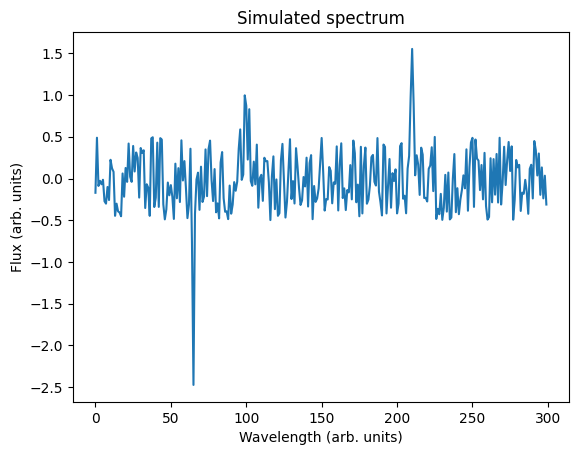

In [319]:
plt.plot(spectra[:,0])
plt.xlabel("Wavelength (arb. units)")
plt.ylabel("Flux (arb. units)")
plt.title("Simulated spectrum")
plt.show()

Now, let's simulate some reddening functions.

In [299]:
def reddening_fn(x, a, b):
    f =  a * np.log(x+50) + b
    return f

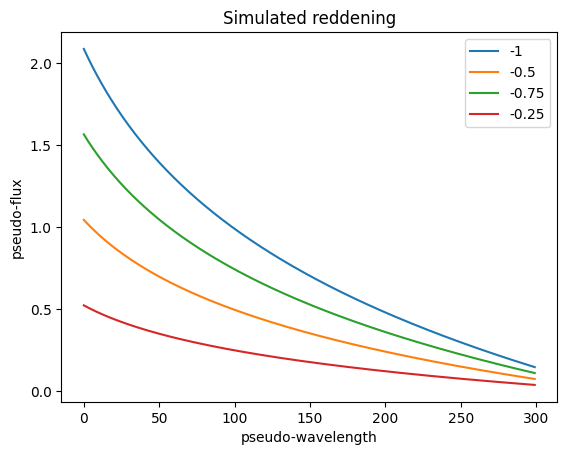

In [320]:
wavelengths = np.arange(n_wavelengths)
plt.plot(reddening_fn(wavelengths, -1, 6), label = '-1')
plt.plot(reddening_fn(wavelengths, -0.5, 3), label = '-0.5')
plt.plot(reddening_fn(wavelengths, -0.75, 4.5), label = '-0.75')
plt.plot(reddening_fn(wavelengths, -0.25, 1.5), label = '-0.25')
plt.xlabel("pseudo-wavelength")
plt.ylabel("pseudo-flux")
plt.legend()
plt.title("Simulated reddening")
plt.show()

We'll use the blue line above for this example. Now, we can add this reddening function to a simulated spectrum.

In [301]:
reddening1 = reddening_fn(wavelengths, -1, 6)
reddened_spectrum = spectra[:,0] + reddening1

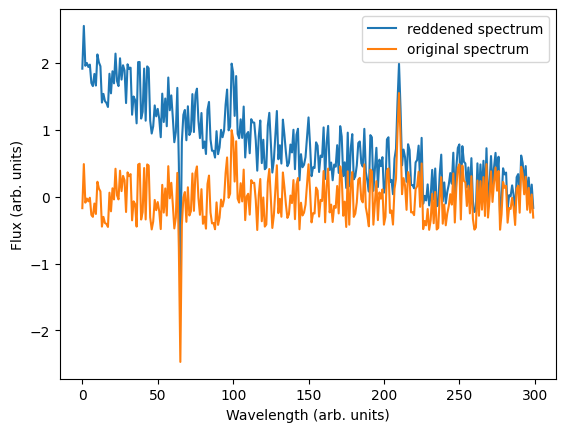

In [318]:
plt.plot(reddened_spectrum, label="reddened spectrum")
plt.plot(spectra[:,0], label="original spectrum")
plt.xlabel("Wavelength (arb. units)")
plt.ylabel("Flux (arb. units)")
plt.legend()
plt.show()

Now, we can use our simulated dataset and the MADGICS formalism to separate out the reddening component from the spectrum.

In [309]:
def make_cov(data):
    if len(data.shape) == 1:
        data = np.expand_dims(data, axis=1)
    median_subtracted_data = data - np.median(data, axis= 0)
    C = np.matmul(median_subtracted_data, median_subtracted_data.T) / data.shape[0]
    return C

In [310]:
reddening_cov = make_cov(reddening1)
spec_cov = make_cov(spectra)
reddening_cov.shape, spec_cov.shape

((300, 300), (300, 300))

In [311]:
def do_madgics(combined_data, C1, C2):
    if len(combined_data.shape) == 1:
        combined_data = np.expand_dims(combined_data, axis=1)
    Ctotinv = np.linalg.inv(C1 + C2)
    extracted1 = np.matmul(np.matmul(C1, Ctotinv), combined_data)
    extracted2 = np.matmul(np.matmul(C2, Ctotinv), combined_data)
    return extracted1, extracted2

In [312]:
reddening_component, spec_component = do_madgics(reddened_spectrum, reddening_cov, spec_cov)

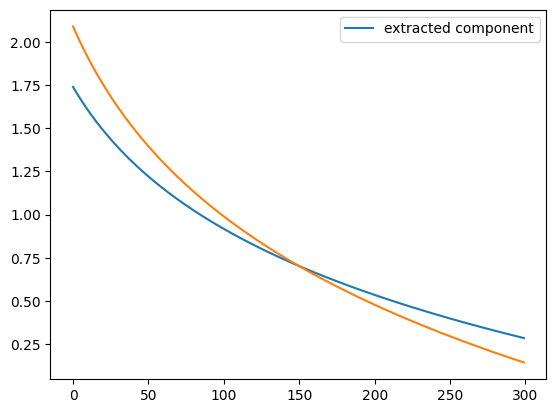

In [313]:
plt.plot(reddening_component + 0.7041889043637357, label='extracted component')
plt.plot(reddening1)
plt.legend()

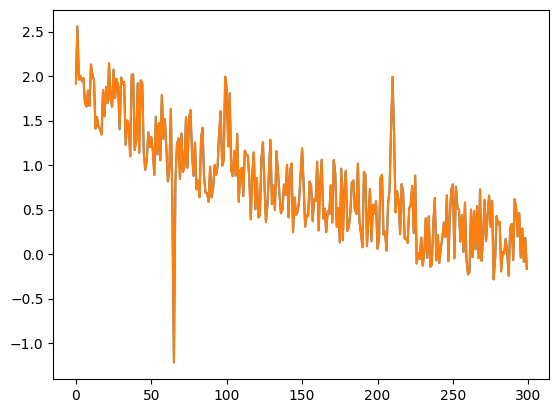

In [291]:
plt.plot(reddening_component + spec_component)
plt.plot(reddened_spectrum)

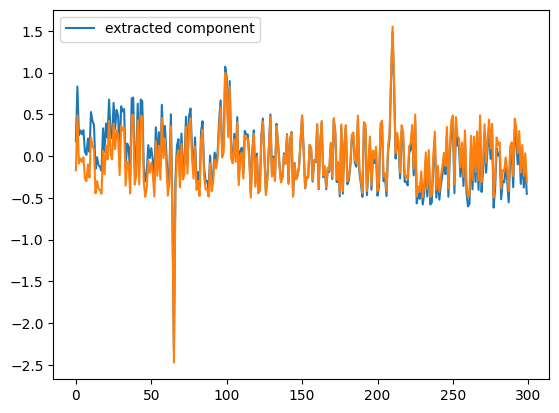

In [314]:
plt.plot(spec_component - 0.7041889043637357, label = 'extracted component')
# plt.plot(spec_component, label = 'extracted component')

plt.plot(spectra[:,0])
plt.legend()
plt.show()